# Python version - Supermodel 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
def dNdt(H, P, PH, N, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    m_H = parameters_dict['m_H'] # Herbivore mortality 
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    m_P = parameters_dict['m_P'] # Predator mortality
    #Unpacking phytoplankton and nutrients parameters: 
    v_m = parameters_dict['v_m'] # max growth rate of phytoplankton
    k_s = parameters_dict['k_s'] # half saturation constant
    m_ph = parameters_dict['m_ph'] # phytoplankton mortality 
    y = parameters_dict['y'] # unassimilated phytoplankton 
    #Unpacking grazing parameters: 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    #more timesteps
    #dt = parameters_dict['dt']
    
    #Calculate the derivative 
    #grazing_t1 = r_m * (kg**-1 * PH * (1 - math.exp(-kg**-1 * PH))) * H
    
    #dH = ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dH = r_H*H*(1-H/K_H) + ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P - m_P * P 
    dPH = ((v_m * N * PH)/(k_s + N)) - (m_ph * PH) - ((r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H)
    dN = -((v_m * N * PH)/(k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H) + (m_P * P)
    
    return dH, dP, dPH, dN

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, PH, N, parameters_dict):
    H_init = H
    P_init = P
    PH_init = PH 
    N_init = N 
    
    dH1, dP1, dPH1, dN1 = dNdt(H, P, PH, N, parameters_dict)
    
    H1 = H + 0.5 * dH1 #* dt
    P1 = P + 0.5 * dP1 #* dt
    PH1 = PH + 0.5 * dPH1 #* dt
    N1 = N + 0.5 * dN1 #* dt
    
    dH2, dP2, dPH2, dN2 = dNdt(H1, P1, PH1, N1, parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2
    dPH_ave = (dPH1+dPH2)/2
    dN_ave = (dN1+dN2)/2
    
    H = (H_init + dH_ave) #* dt #(include as another param)
    P = (P_init + dP_ave) #* dt
    PH = (PH_init + dPH_ave) #* dt 
    N = (N_init + dN_ave) #* dt
    
    if H < 0:
        H = 0 
        
    if P < 0:
        P = 0 
    
    if PH < 0:
        PH = 0 
        
    if N < 0:
        N = 0 
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    #Calculate grazing 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    
    grazing = r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H
    
    return H, P, PH, N, herbivore_harvest, predator_harvest, grazing

In [4]:
# Function to run the model 

def run_model(INIT_H, INIT_P, INIT_PH, INIT_N, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    PH_array = np.zeros(numyears+1)
    N_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    grazing_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore
    P_array[0] = INIT_P #Starting biomass of predator 
    PH_array[0] = INIT_PH #Starting biomass of phytoplankton
    N_array[0] = INIT_N #Starting biomass of nutrients
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    grazing_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], PH_array[i+1], N_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1], grazing_array[i+1], \
            = RK2(H_array[i], P_array[i], PH_array[i], N_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array

# Test

In [5]:
numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.4 # prey growth rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = 0.2 # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = 0.0 # Effort for herbivore harvest
m_H = 0.01 # Herbivore mortality 

#Predator parameters:
r_P = 0.4 # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = 0.2 # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = 0.0 # Effort for predator harvest
m_P = 0.01 # Predator mortality

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality 
y = 0.1 # unassimilated phytoplankton

#Grazing parameters: 
r_m = 1.1 # grazing of fish on phytoplankton
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P, 
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }


In [6]:
H0 = 20
P0 = 5
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

NameError: name 'np' is not defined

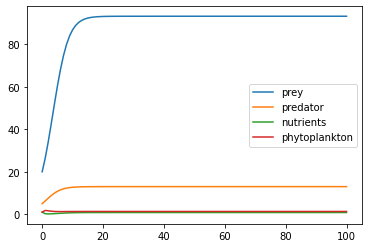

In [151]:
plt.plot(H_array, label="prey")
plt.plot(P_array, label="predator")
plt.plot(N_array, label="nutrients")
plt.plot(PH_array, label="phytoplankton")
plt.legend()

In [152]:
PH_array

array([1.        , 1.80047888, 1.63179104, 1.43844422, 1.32495347,
       1.27788587, 1.26760562, 1.27261316, 1.28126965, 1.2896895 ,
       1.29731785, 1.3040266 , 1.30954349, 1.31373912, 1.31674352,
       1.31882371, 1.32024333, 1.32120483, 1.32185094, 1.32228161,
       1.32256707, 1.32275584, 1.32288059, 1.322963  , 1.32301738,
       1.32305324, 1.32307688, 1.32309245, 1.32310272, 1.32310948,
       1.32311394, 1.32311688, 1.32311881, 1.32312008, 1.32312092,
       1.32312148, 1.32312184, 1.32312208, 1.32312224, 1.32312235,
       1.32312241, 1.32312246, 1.32312249, 1.32312251, 1.32312252,
       1.32312253, 1.32312254, 1.32312254, 1.32312254, 1.32312254,
       1.32312254, 1.32312255, 1.32312255, 1.32312255, 1.32312255,
       1.32312255, 1.32312255, 1.32312255, 1.32312255, 1.32312255,
       1.32312255, 1.32312255, 1.32312255, 1.32312255, 1.32312255,
       1.32312255, 1.32312255, 1.32312255, 1.32312255, 1.32312255,
       1.32312255, 1.32312255, 1.32312255, 1.32312255, 1.32312

## Add Conversion Efficiency ? 

In [68]:
def dNdt(H, P, PH, N, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    m_H = parameters_dict['m_H'] # Herbivore mortality 
    e_H = parameters_dict['e_H'] # conversion efficiency for herb
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    m_P = parameters_dict['m_P'] # Predator mortality
    e_P = parameters_dict['e_P'] # conversion efficiency for pred
    #Unpacking phytoplankton and nutrients parameters: 
    v_m = parameters_dict['v_m'] # max growth rate of phytoplankton
    k_s = parameters_dict['k_s'] # half saturation constant
    m_ph = parameters_dict['m_ph'] # phytoplankton mortality 
    y = parameters_dict['y'] # unassimilated phytoplankton 
    #Unpacking grazing parameters: 
    r_m = parameters_dict['r_m'] # grazing of fish on phytoplankton
    kg = parameters_dict['kg']
    #more timesteps
    #dt = parameters_dict['dt']
    
    #Calculate the derivative 
    #grazing_t1 = r_m * (kg**-1 * PH * (1 - math.exp(-kg**-1 * PH))) * H
    
    #dH = ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dH = r_H*e_H*H*(1-H/K_H) + ((1-y) * r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH))) * H)*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H - m_H*H
    dP = ((r_P*e_P*P)*(1-P/K_P)) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P - (m_P * P * P)
    dPH = ((v_m * N * PH)/(k_s + N)) - (m_ph * PH) - ((r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H)
    dN = -((v_m * N * PH)/(k_s + N)) + (m_ph * PH) + (m_H * H) + (y * (r_m * (kg**-1 * PH * (1 - np.exp(-kg**-1 * PH)))) * H) + (m_P * P * P)
    
    return dH, dP, dPH, dN

In [107]:
numyears = 10000 # number of years to run simulation 

#Herbivore parameters:
r_H = (0.3/365) # prey daily ingestion rate
K_H = 100 # carrying capacity of herbivores
theta_H = 0 # immigration of herbivores
c = 0.2 # addition to predator from prey
d = 50 # value of H when predation half its max value
q_H = 1.0 # proportionality constant for herbivore harvest
E_H = 0.0 # Effort for herbivore harvest
m_H = (0.3/365) # Herbivore mortality 
e_H = 1

#Predator parameters:
r_P = (50/365) # growth rate of predator 
K_P = 10 # carrying capactiy of predators 
b = 0.2 # mortality to prey from predator
theta_P = 0 # immigration of predators  
q_P = 1.0 # proportionality constant for predators harvest
E_P = 0.1 # Effort for predator harvest
m_P = (0.01/365) # Predator mortality
e_P = 1.0

#Phytoplankton parameters: 
v_m = (2.0) # max growth rate of phytoplankton
k_s = 1 # half saturation constant
m_ph = (0.01) # phytoplankton mortality 
y = 0.1 # unassimilated phytoplankton

#Grazing parameters: 
r_m = 3.65 # grazing of fish on phytoplankton
kg = 12
# Timesteps
dt = 0.1

parameters_dict = {'numyears': numyears,
                  'r_H': r_H,
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H,
                  'm_H': m_H,
                  'e_H': e_H,
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  'm_P': m_P,
                  'e_P': e_P,
                  'v_m': v_m,
                  'k_s': k_s, 
                  'm_ph': m_ph, 
                  'y': y, 
                  'r_m': r_m, 
                  'kg': kg,
                  'dt': dt
                  }

In [108]:
H0 = 100
P0 = 10
PH0 = 1
N0 = 1

H_array, P_array, PH_array, N_array, H_harvest_array, P_harvest_array, grazing_array = run_model(H0, P0, PH0, N0, parameters_dict)

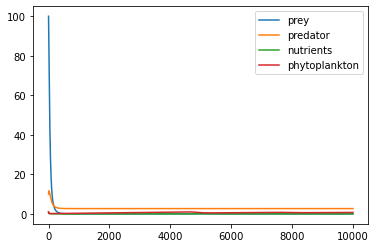

In [109]:
plt.plot(H_array, label="prey")
plt.plot(P_array, label="predator")
plt.plot(N_array, label="nutrients")
plt.plot(PH_array, label="phytoplankton")
plt.legend()

In [110]:
P_array

array([10.        , 10.32018767, 10.59933471, ...,  2.70036223,
        2.70037151,  2.7003808 ])

#### as predator growth decreases, pred pop is increasing

###### as pred growth rate increases, too effiecent at eating prey; prey pop intially spikes and then pred follows w/ spike, but then growing fast so eats all the prey 

#### not sensitive to growth, but very sensitive to mortality 